# Air B&B Data- Plots and Predictions on IBM Cloud
---

In [56]:
# Install packages
import sys
#!{sys.executable} -m pip install geopandas
#!{sys.executable} -m pip install contextily
!{sys.executable} -m pip install matplotlib

In [57]:
# Import libraries
import pandas as pd
from project_lib import Project
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import tensorflow
tensorflow.random.set_seed(100)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [6]:
# Initialize repo
project = Project(project_id = '5afe2bf8-1648-4882-9498-b17ae00b7d12', 
                  project_access_token = 'p-763d1287a282da2e9a226964f99199fefdae8b10')

pc = project.project_context

In [7]:
# Get data
f = project.get_file('AB_US_2020.csv')
f.seek(0)
df = pd.read_csv(f)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [9]:
# Inspect
print('Shape of Dataset: ', df.shape)
print('Available features-')
print(df.columns)
print('Missing Values:')
print(df.isnull().sum())

Shape of Dataset:  (226030, 17)
Available features-
Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city'],
      dtype='object')
Missing Values:
id                                     0
name                                  28
host_id                                0
host_name                             33
neighbourhood_group               115845
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        48602
reviews_per_month                  48602
calculated_host_listings_count        

In [10]:
# Create geodata for plotting
df['loc'] = list(zip(df.longitude, df.latitude))
gdf = gpd.GeoDataFrame(df, crs  ={'init': 'epsg:4326'}, geometry = df['loc'].apply(Point)).to_crs(epsg = 3857)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


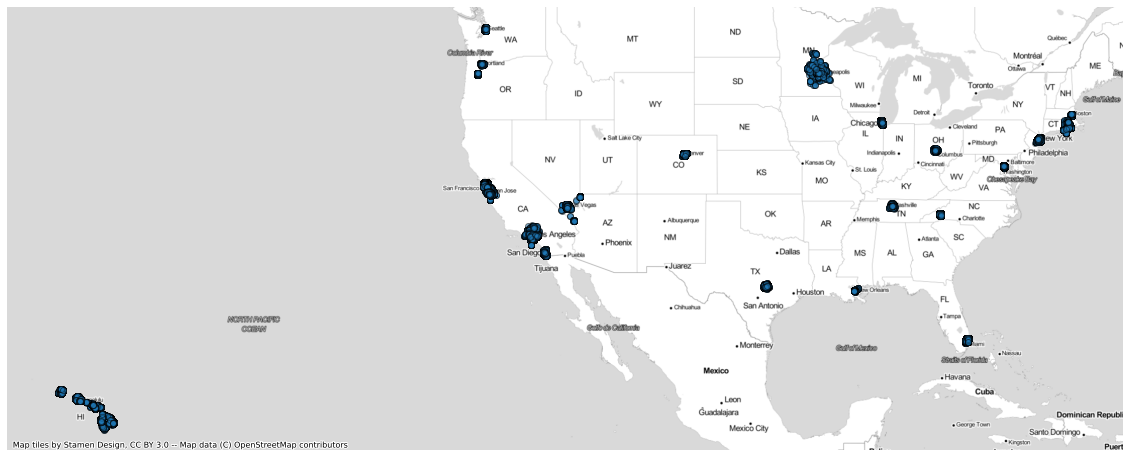

In [11]:
# Visualize
ax = gdf.plot(figsize = (20, 20), alpha = 0.5, edgecolor = 'k')
ctx.add_basemap(ax, source = ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [12]:
# Subset data for specific area
lagdf = gdf.loc[gdf['city'] == 'Los Angeles']
print('LA contains {} listings..'.format(lagdf.shape[0]))

LA contains 31536 listings..


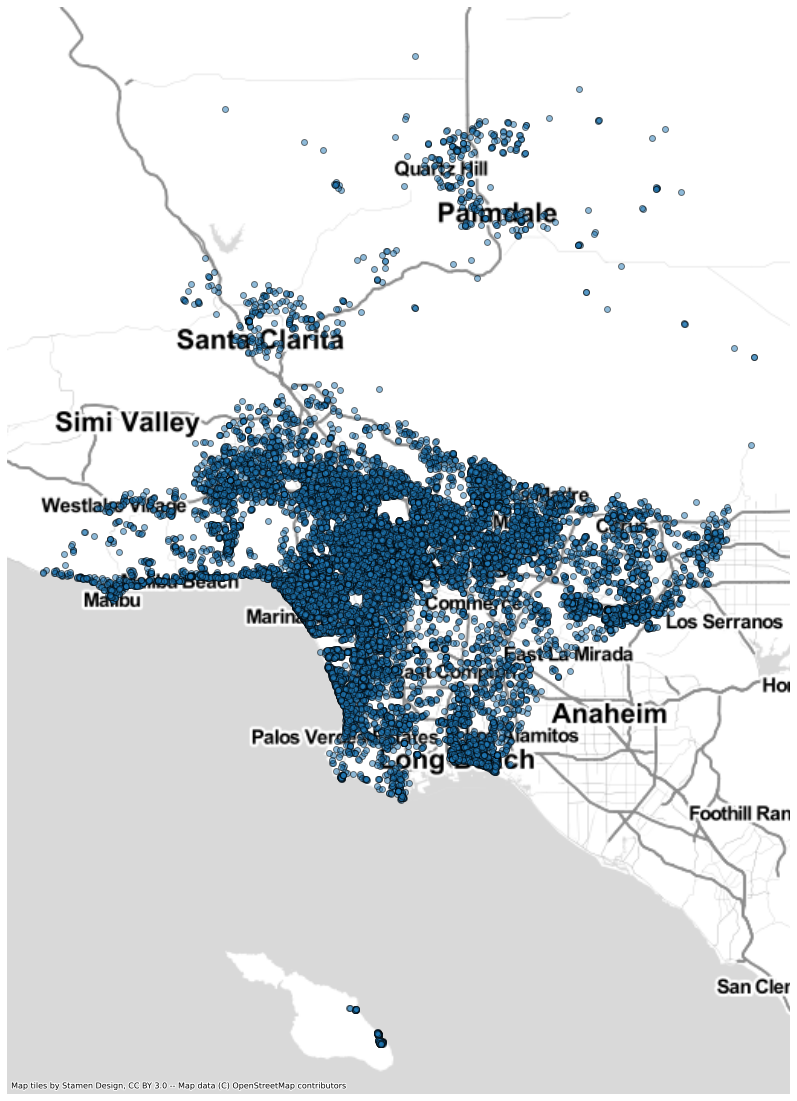

In [13]:
# Visualize
ax = lagdf.plot(figsize = (20, 20), alpha = 0.5, edgecolor = 'k')
ctx.add_basemap(ax, source = ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [14]:
%time tempe = ctx.Place("Los Angeles, CA")

CPU times: user 262 ms, sys: 72.3 ms, total: 335 ms
Wall time: 2.18 s


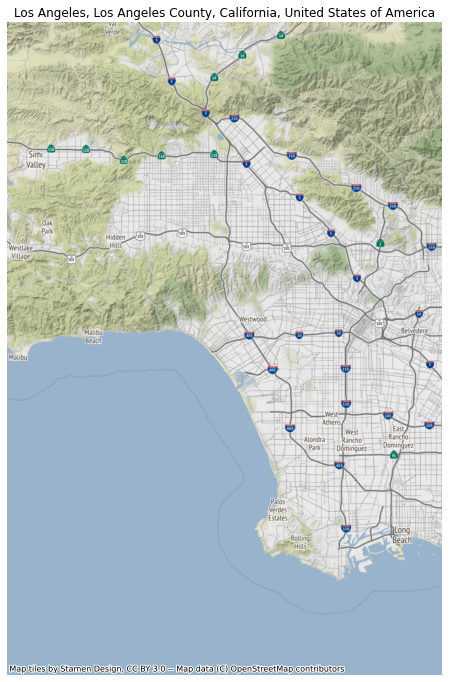

In [15]:
tempe.plot()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 9 is not valid for the current tile provider (valid zooms: 1 - 8).
  warnings.warn(msg)


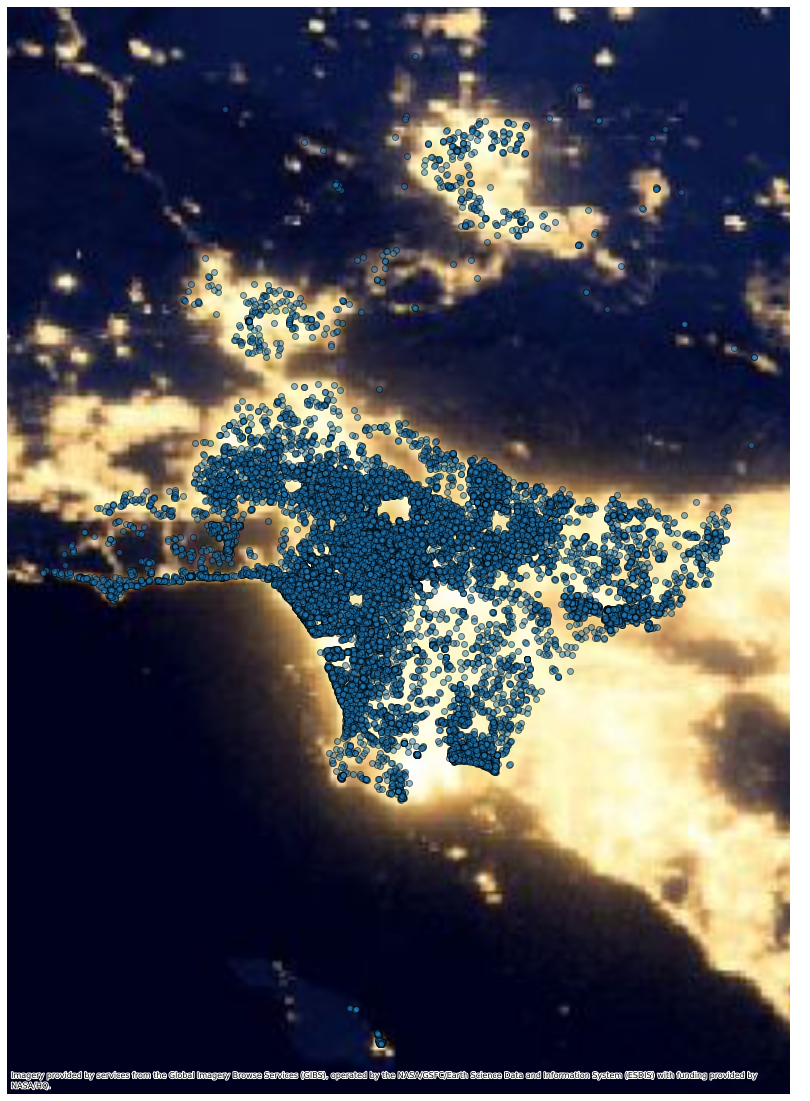

In [16]:
# Visualize
ax = lagdf.plot(figsize = (20, 20), alpha = 0.5, edgecolor = 'k')
ctx.add_basemap(ax, source = ctx.providers.NASAGIBS.ViirsEarthAtNight2012)
ax.set_axis_off()

In [38]:
# Drop unneeded
df1 = df.drop(['id', 'name', 'host_name', 'neighbourhood_group', 'latitude', 'longitude', 'last_review', 'loc', 'geometry'], axis = 1)

In [39]:
df1.head()

,host_id,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,city
0,165529,28804,Private room,60,1,138,1.14,1,0,Asheville
1,427027,28801,Entire home/apt,470,1,114,1.03,11,288,Asheville
2,320564,28801,Entire home/apt,75,30,89,0.81,2,298,Asheville
3,746673,28806,Entire home/apt,90,1,267,2.39,5,0,Asheville
4,769252,28801,Private room,125,30,58,0.52,1,0,Asheville


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [41]:
le = LabelEncoder()

for col in ['room_type', 'neighbourhood', 'city']:
    
    df1[col] = le.fit_transform(df1[col])

In [46]:
df1.isnull().sum()

host_id                               0
neighbourhood                         0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 48602
calculated_host_listings_count        0
availability_365                      0
city                                  0
dtype: int64

In [47]:
df1['reviews_per_month'] = df1['reviews_per_month'].fillna(0)

In [48]:
import numpy as np

# Split variables
y = df1['price'].values
x = df1[[i for i in df1.columns if i != 'price']].values

x = np.asarray(x).astype('float32')
y = np.asarray(y).astype('float32')

# Split data
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size = .2, random_state = 100)

In [49]:
len(xtrain)

180824

In [52]:
# Build NN
# Input- fts + 1
nn = Sequential()
nn.add(Dense(10, input_dim = 9, kernel_initializer = 'normal', activation = 'relu'))
nn.add(Dense(1800, activation = 'relu'))
nn.add(Dense(1, activation = 'linear'))
nn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                100       
_________________________________________________________________
dense_13 (Dense)             (None, 1800)              19800     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 1801      
Total params: 21,701
Trainable params: 21,701
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Predict
nn.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse','mae'])
h = nn.fit(xtrain, ytrain, epochs = 5, batch_size = 1000, verbose = 1, validation_split = 0.2)
preds = nn.predict(xval)

Train on 144659 samples, validate on 36165 samples
Epoch 1/5
144659/144659 [==============================] - 73s 507us/sample - loss: 2381656219.3462 - mse: 2381656576.0000 - mae: 17015.2578 - val_loss: 51293329.3687 - val_mse: 51293324.0000 - val_mae: 5039.1465
Epoch 2/5
144659/144659 [==============================] - 74s 509us/sample - loss: 155442373.5796 - mse: 155442368.0000 - mae: 787.3318 - val_loss: 1818837.0203 - val_mse: 1818836.8750 - val_mae: 930.4257
Epoch 3/5
144659/144659 [==============================] - 73s 508us/sample - loss: 38914725.4629 - mse: 38914716.0000 - mae: 426.7950 - val_loss: 498657.9300 - val_mse: 498657.9688 - val_mae: 326.0733
Epoch 4/5
144659/144659 [==============================] - 74s 515us/sample - loss: 1218015.7580 - mse: 1218015.6250 - mae: 265.4685 - val_loss: 416660.5660 - val_mse: 416660.5625 - val_mae: 189.2600
Epoch 5/5
144659/144659 [==============================] - 74s 511us/sample - loss: 487591.7121 - mse: 487591.7500 - mae: 223.24

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


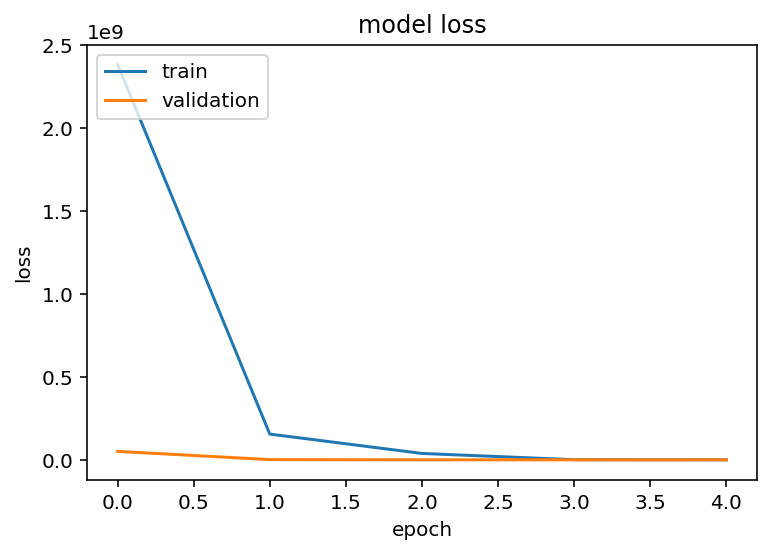

In [58]:
# Visualize performance
print(h.history.keys())
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [59]:
mean_absolute_error(yval, preds)

223.15317